<a href="https://colab.research.google.com/github/yeongjinHwang/CNN/blob/renet-5/reNet-5/reNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

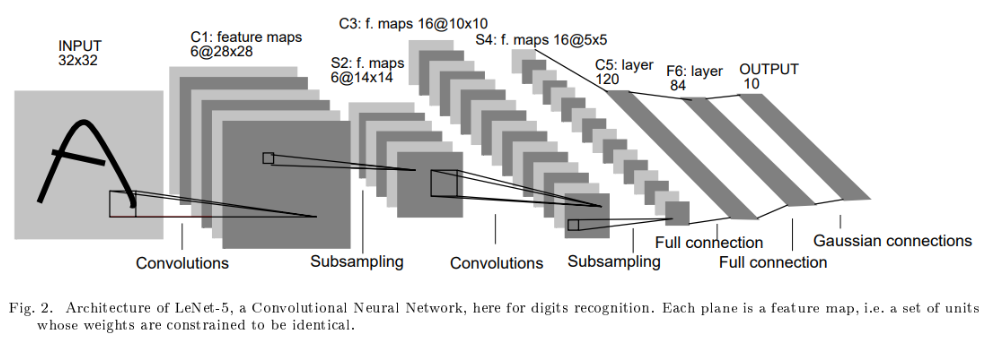

In [ ]:
# LeNet-5 Model Definition
class LeNet5(nn.Module):
    """
    LeNet-5 Model Architecture
    Input :
        1x32x32 binary image
    Output :
        10
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Avg pooling layer (subsampling)
        # Convolutional layers by LeNet-5 architecture
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv5(x))
        x = torch.flatten(x, 1)  # Flatten the tensor to [batch_size, 120]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Final layer without activation for CrossEntropyLoss
        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------
Initial Conv1 filters (weights):
[[[[ 0.04056227 -0.00671947 -0.00449142  0.00177484 -0.00332506]
   [ 0.024

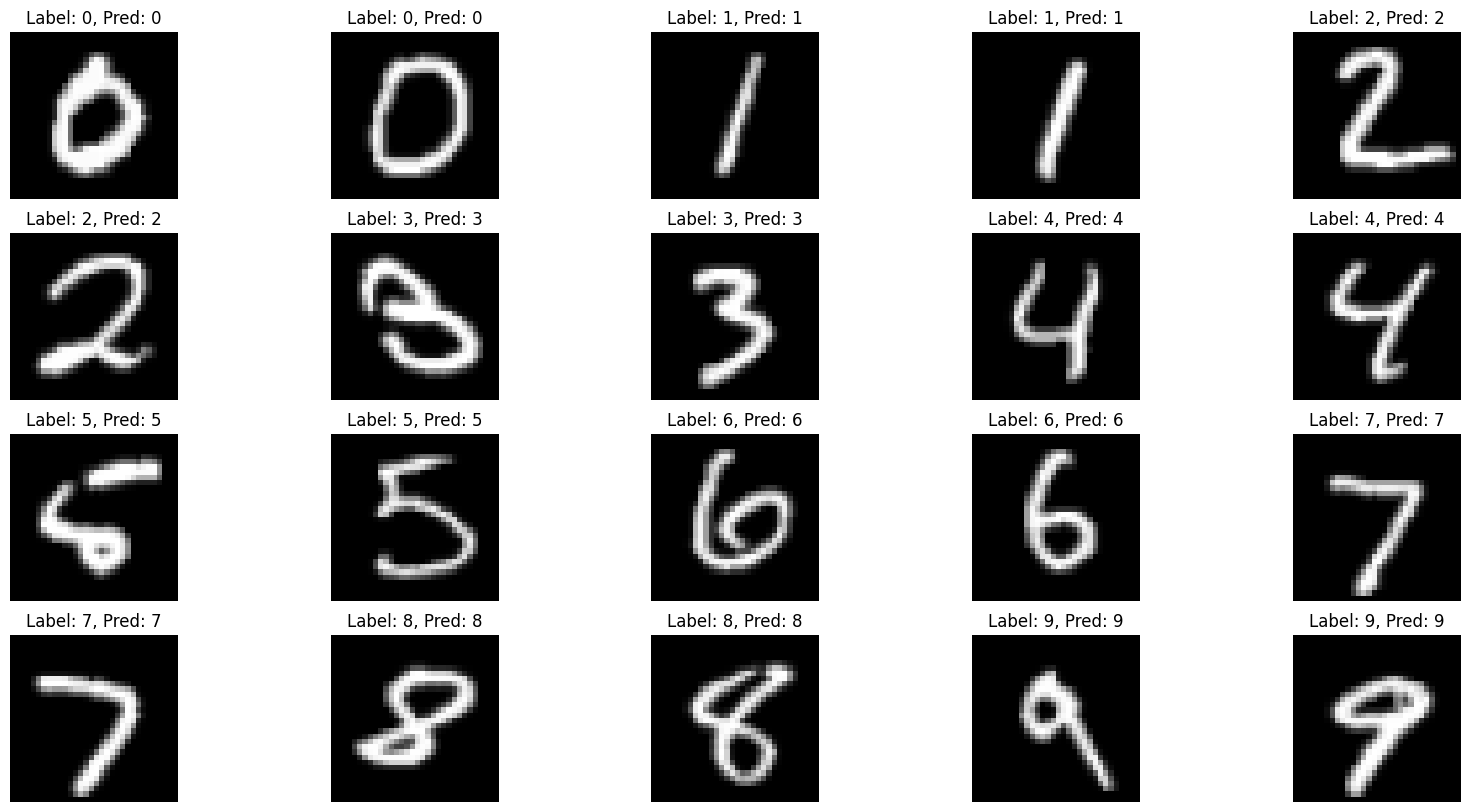

In [ ]:
if __name__ == '__main__':
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model summary
    model = LeNet5().to(device)  # Create model and move to GPU if available
    summary(model, input_size=(1, 32, 32))  # (channels, height, width)

    # Initial weights
    print("Initial Conv1 filters (weights):")
    print(model.conv1.weight.data.cpu().numpy())

    # Optimizer and loss function
    learning_rate = 0.01
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Gradient Descent Optimizer
    loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

    # Data Preparation
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # 60,000 image
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True) # 10,000 image

    # Create DataLoader for batch processing
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()  # Set to training mode
        running_loss = 0.0
        for images, labels in train_loader:
            # Move data to the same device as the model (GPU if available)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Weights after training
    print("\nTrained Conv1 filters (weights):")
    print(model.conv1.weight.data.cpu().numpy())

    # Testing the model on two images for each digit from 0 to 9
    model.eval()  # Set to evaluation mode

    # Select two images for each digit (0-9) from the test dataset
    selected_images = []
    selected_labels = []
    count = {i: 0 for i in range(10)}  # To keep track of how many images per digit are selected

    for image, label in test_dataset:
        if count[label] < 2:  # Select only 2 images per digit
            selected_images.append(image)
            selected_labels.append(label)
            count[label] += 1
        if all(c == 2 for c in count.values()):
            break

    # Display the images and model predictions
    plt.figure(figsize=(20, 10))

    # Sort selected images by label
    sorted_indices = sorted(range(len(selected_labels)), key=lambda i: selected_labels[i])

    for i, idx in enumerate(sorted_indices):
        image = selected_images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        label = selected_labels[idx]
        output = model(image)
        _, predicted = torch.max(output.data, 1)

        # Plot the image
        plt.subplot(4, 5, i + 1)
        plt.imshow(image.cpu().squeeze(), cmap='gray')  # Move back to CPU for plotting
        plt.title(f'Label: {label}, Pred: {predicted.item()}')
        plt.axis('off')

    plt.show()
